# Network in Network (NiN)

LeNet, AlexNet, and VGG all share a common design pattern:
extract features exploiting *spatial* structure
via a sequence of convolutions and pooling layers
and post-process the representations via fully connected layers.
The improvements upon LeNet by AlexNet and VGG mainly lie
in how these later networks widen and deepen these two modules.

This design poses two major challenges.
First, the fully connected layers at the end
of the architecture consume tremendous numbers of parameters. For instance, even a simple
model such as VGG-11 requires a monstrous matrix, occupying almost
400MB of RAM in single precision (FP32). This is a significant impediment to computation, in particular on
mobile and embedded devices. After all, even high-end mobile phones sport no more than 8GB of RAM. At the time VGG was invented, this was an order of magnitude less (the iPhone 4S had 512MB). As such, it would have been difficult to justify spending the majority of memory on an image classifier.

Second, it is equally impossible to add fully connected layers
earlier in the network to increase the degree of nonlinearity: doing so would destroy the
spatial structure and require potentially even more memory.

The *network in network* (*NiN*) blocks :cite:`Lin.Chen.Yan.2013` offer an alternative,
capable of solving both problems in one simple strategy.
They were proposed based on a very simple insight: (i) use $1 \times 1$ convolutions to add
local nonlinearities across the channel activations and (ii) use global average pooling to integrate
across all locations in the last representation layer. Note that global average pooling would not
be effective, were it not for the added nonlinearities. Let's dive into this in detail.


In [1]:
!pip install d2l --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sour

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## (**NiN Blocks**)

Recall :numref:`subsec_1x1`. In it we said that the inputs and outputs of convolutional layers
consist of four-dimensional tensors with axes
corresponding to the example, channel, height, and width.
Also recall that the inputs and outputs of fully connected layers
are typically two-dimensional tensors corresponding to the example and feature.
The idea behind NiN is to apply a fully connected layer
at each pixel location (for each height and width).
The resulting $1 \times 1$ convolution can be thought of as
a fully connected layer acting independently on each pixel location.

:numref:`fig_nin` illustrates the main structural
differences between VGG and NiN, and their blocks.
Note both the difference in the NiN blocks (the initial convolution is followed by $1 \times 1$ convolutions, whereas VGG retains $3 \times 3$ convolutions) and at the end where we no longer require a giant fully connected layer.

![Comparing the architectures of VGG and NiN, and of their blocks.](../images/nin.svg)
:width:`600px`
:label:`fig_nin`


In [8]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

## [**NiN Model**]

NiN uses the same initial convolution sizes as AlexNet (it was proposed shortly thereafter).
The kernel sizes are $11\times 11$, $5\times 5$, and $3\times 3$, respectively,
and the numbers of output channels match those of AlexNet. Each NiN block is followed by a max-pooling layer
with a stride of 2 and a window shape of $3\times 3$.

The second significant difference between NiN and both AlexNet and VGG
is that NiN avoids fully connected layers altogether.
Instead, NiN uses a NiN block with a number of output channels equal to the number of label classes, followed by a *global* average pooling layer,
yielding a vector of logits.
This design significantly reduces the number of required model parameters, albeit at the expense of a potential increase in training time.


In [9]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

We create a data example to see [**the output shape of each block**].


In [4]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [5]:
model = NiN()
X = torch.rand(size=(1, 1, 224, 224))
model(X)
print(f"{sum([layer.numel() for layer in model.parameters()]):,.0f}")

1,992,166


Just a million parameters! (Well 2 million)

## [**Training**]

As before we use Fashion-MNIST to train the model using the same
optimizer that we used for AlexNet and VGG.


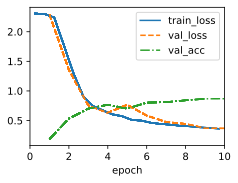

In [6]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [7]:
print(model.board.data['val_acc'][-1])

Point(x=10.0, y=0.8680775316455697)


## Summary

NiN has dramatically fewer parameters than AlexNet and VGG. This stems primarily from the fact that it needs no giant fully connected layers. Instead, it uses global average pooling to aggregate across all image locations after the last stage of the network body. This obviates the need for expensive (learned) reduction operations and replaces them by a simple average. What surprised researchers at the time was the fact that this averaging operation did not harm accuracy. Note that averaging across a low-resolution representation (with many channels) also adds to the amount of translation invariance that the network can handle.

Choosing fewer convolutions with wide kernels and replacing them by $1 \times 1$ convolutions aids the quest for fewer parameters further. It can cater for a significant amount of nonlinearity across channels within any given location. Both $1 \times 1$ convolutions and global average pooling significantly influenced subsequent CNN designs.

## Exercises


1. Why are there two $1\times 1$ convolutional layers per NiN block? Increase their number to three. Reduce their number to one. What changes?



In [13]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=3, padding=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=3, padding=1), nn.ReLU())

class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

In [14]:
NiN().layer_summary((1, 3, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [15]:
model = NiN()
X = torch.rand(size=(1, 1, 224, 224))
model(X)
print(f"{sum([layer.numel() for layer in model.parameters()]):,.0f}")

5,549,094


> Now 5.5 million!!!

2. What happens if you replace the global average pooling by a fully connected layer (speed, accuracy, number of parameters)?

In [13]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [14]:
model = NiN()
X = torch.rand(size=(1, 1, 224, 224))
model(X)
print(f"{sum([layer.numel() for layer in model.parameters()]):,.0f}")

41,324,042


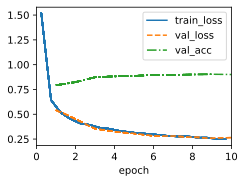

In [15]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [16]:
print(model.board.data['val_acc'][-1])

Point(x=10.0, y=0.9006131329113924)


> Now we are trying **directly, without the intermidiate linear layer**.

In [17]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nn.Flatten(),
            #nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [18]:
model = NiN()
X = torch.rand(size=(1, 1, 224, 224))
model(X)
print(f"{sum([layer.numel() for layer in model.parameters()]):,.0f}")

2,053,386


> It significantly reduces the number of weights than the actual intermediate layer!

Point(x=10.0, y=0.9037776898734177)


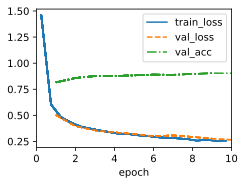

In [19]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)
print(model.board.data['val_acc'][-1])

This is fascinating!!!

[Discussions](https://discuss.d2l.ai/t/80)
